In [154]:
import pathlib as pl
from configparser import ConfigParser

import joblib as jl
import numpy as np
import scipy.stats as sst
from statsmodels.formula.api import ols
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, display

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from nems_lbhb.baphy_io import  get_mean_spike_waveform

from src.data.load import load
from src.root_path import config_path
from src.visualization.palette import *
from src.utils.dataframes import add_classified_contexts
from src.data.cell_type import get_phototags
from src.root_path import config_path



config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

In [41]:
# quick and dirty, get the celltype dataframe, merge to main DF and run categorical linear regressions
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '210816_CPN_celltype_DF'
type_DF = jl.load(type_DF_file)
type_DF = type_DF.loc[:, ['id', 'spike_type', 'phototag']]
type_DF.dropna(subset=['spike_type', 'phototag'], how='all')
type_DF.head()

,id,spike_type,phototag
0,TNC010a-007-4,broad,NaN
1,TNC010a-027-3,broad,NaN
2,TNC010a-031-3,broad,NaN
3,TNC010a-039-1,narrow,NaN
4,TNC010a-040-1,broad,NaN


In [42]:
# Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'

metrics = ['integral', 'last_bin']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"value > 0 and value < 10000")

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(91816, 8)


,id,context_pair,probe,value,metric,site,region,trans_pair
0,CRD004a-22-1,00_01,1,151.889679,integral,CRD004a,A1,same_silence
1,CRD004a-39-2,00_01,1,45.823387,integral,CRD004a,A1,same_silence
2,CRD004a-46-3,00_01,1,349.813538,integral,CRD004a,A1,same_silence
3,CRD004a-62-1,00_01,1,128.190765,integral,CRD004a,A1,same_silence
4,CRD004a-64-1,00_01,1,346.058807,integral,CRD004a,A1,same_silence


In [43]:
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress, type_DF, on='id', validate="m:1")

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff same silence
mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)

onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)
print(toregress.shape)
toregress.head()

(89564, 15)


,id,context_pair,probe,value,metric,site,region,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence
0,TNC010a-027-3,00_01,1,335.909668,integral,TNC010a,A1,same_silence,236.439667,1.420699,broad,NaN,0,1,1
1,TNC010a-027-3,00_02,1,413.742401,integral,TNC010a,A1,diff_silence,236.439667,1.749886,broad,NaN,1,0,1
2,TNC010a-027-3,00_04,1,352.295502,integral,TNC010a,A1,diff_silence,236.439667,1.490002,broad,NaN,1,0,1
3,TNC010a-027-3,00_08,1,372.777802,integral,TNC010a,A1,diff_silence,236.439667,1.576630,broad,NaN,1,0,1
4,TNC010a-027-3,00_10,1,352.295502,integral,TNC010a,A1,diff_silence,236.439667,1.490002,broad,NaN,1,0,1


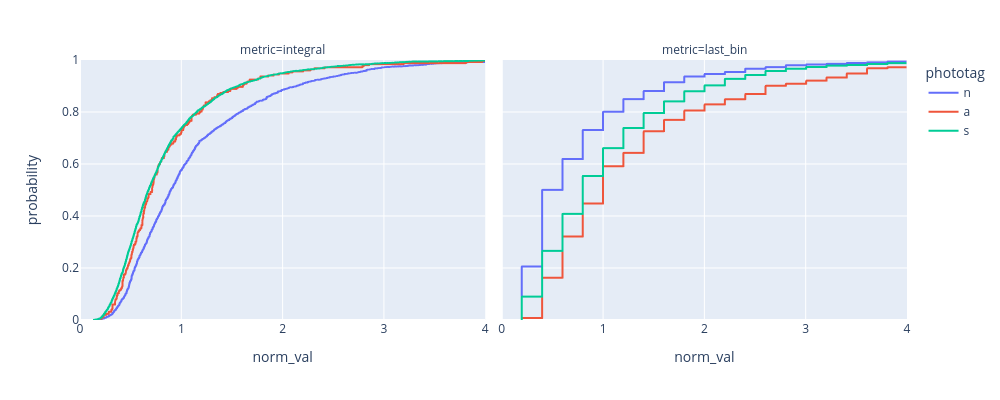

In [77]:
toplot = toregress.dropna(subset='phototag')

fig = px.ecdf(toplot, x="norm_val",  color='phototag', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [79]:
d = toregress.query("metric == 'integral'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     165.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           4.93e-71
Time:                        10:47:50   Log-Likelihood:                -8354.5
No. Observations:                8145   AIC:                         1.672e+04
Df Residuals:                    8142   BIC:                         1.674e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8797      0.043  

In [82]:
d = toregress.query("metric == 'last_bin'").dropna(subset='phototag')
mod = ols("norm_val ~ C(phototag)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     170.3
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           3.35e-73
Time:                        10:50:15   Log-Likelihood:                -9029.3
No. Observations:                8145   AIC:                         1.806e+04
Df Residuals:                    8142   BIC:                         1.809e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2888      0.046  

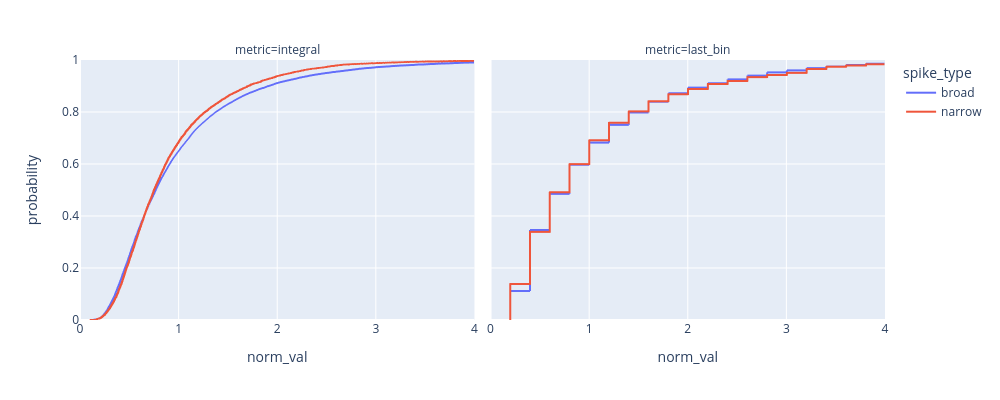

In [83]:
toplot = toregress.dropna(subset='spike_type')

fig = px.ecdf(toplot, x="norm_val",  color='spike_type', facet_col='metric')
fig.update_xaxes(range=[0,4])
fig.update_yaxes(range=[0,1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [84]:
d = toregress.query("metric == 'last_bin'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0008638
Date:                Wed, 17 Aug 2022   Prob (F-statistic):              0.977
Time:                        10:50:34   Log-Likelihood:                -51102.
No. Observations:               40991   AIC:                         1.022e+05
Df Residuals:                   40989   BIC:                         1.022e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [69]:
d = toregress.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(spike_type)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     70.10
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           5.81e-17
Time:                        10:19:12   Log-Likelihood:                -46011.
No. Observations:               40991   AIC:                         9.203e+04
Df Residuals:                   40989   BIC:                         9.204e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# double classification
now look only at those neurons that have both a phototag and a waveform
we have then a (broad, narrow) by (n, a, s) cartesian product. Some of these combinations are of note:

Narrow * activated -> Unequivocaly inhibitory interneuronse
Broad * suppressed -> most likely pyramidal neurons

Narrow * suppressed -> putative inhibitory interneurons ?
Broad * activated -> this should *NOT EXIST*. Inhibitory interneuron have narrow waveforms

Narrow * non-responsive -> putative inhibitory
Broad * non-responsive -> putative exitatory <- check this groups


In [97]:
double_df = toregress.dropna(subset=['spike_type', 'phototag'], how='any').copy()
double_df['double_class'] = double_df['spike_type'].astype(str) + '_' + double_df['phototag'].astype(str)
double_df['double_class'] = double_df['double_class'].astype('category')
double_df.reset_index(drop=True, inplace=True)
double_df.head()

,id,context_pair,probe,value,metric,site,region,trans_pair,grand_mean,norm_val,spike_type,phototag,diff,same,silence,double_class
0,TNC006a-09-1,00_01,1,68.793503,integral,TNC006a,A1,same_silence,236.439667,0.290956,broad,n,0,1,1,broad_n
1,TNC006a-09-1,00_05,1,108.621323,integral,TNC006a,A1,diff_silence,236.439667,0.459404,broad,n,1,0,1,broad_n
2,TNC006a-09-1,00_07,1,336.726105,integral,TNC006a,A1,diff_silence,236.439667,1.424152,broad,n,1,0,1,broad_n
3,TNC006a-09-1,01_02,1,61.552082,integral,TNC006a,A1,diff_same,236.439667,0.260329,broad,n,1,1,0,broad_n
4,TNC006a-09-1,01_06,1,61.552082,integral,TNC006a,A1,diff_same,236.439667,0.260329,broad,n,1,1,0,broad_n


In [94]:
# count of neuronse per category
double_df.groupby(by=['id','double_class']).agg(value = ('value', 'mean')
                                                ).groupby('double_class').agg(count=('value', 'count'))

,count
double_class,
broad_a,4
broad_n,47
broad_s,78
narrow_a,5
narrow_n,14
narrow_s,24


In [95]:
# count of instances per category
double_df.groupby('double_class').agg(count=('value', 'count'))

,count
double_class,
broad_a,352
broad_n,4972
broad_s,6652
narrow_a,138
narrow_n,1362
narrow_s,1150


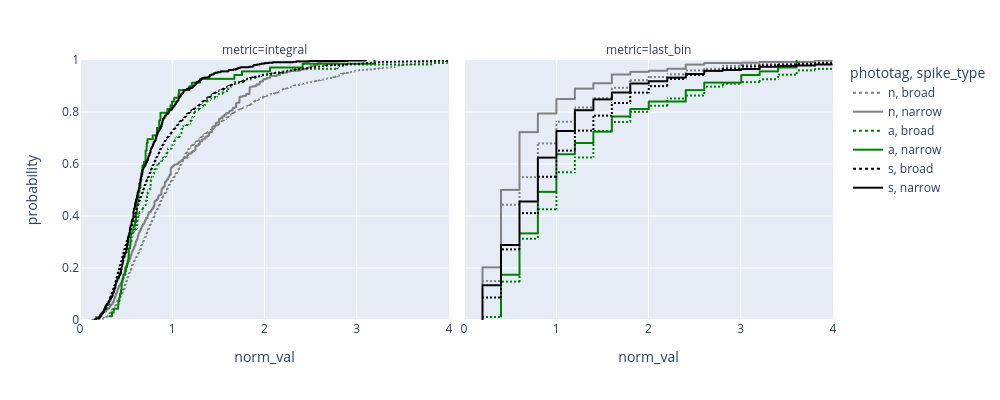

In [99]:
toplot = double_df

fig = px.ecdf(toplot, x="norm_val", color='phototag', line_dash='spike_type', facet_col='metric',
              color_discrete_map={"a": "green",
                                  "s": "black",
                                  "n": "gray"},
              line_dash_map={'narrow': 'solid',
                             'broad': 'dot'}
              )
fig.update_xaxes(range=[0, 4])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [98]:
d = double_df.query("metric == 'integral'").dropna(subset='spike_type')
mod = ols("norm_val ~ C(double_class)", data=d)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     83.26
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.54e-85
Time:                        11:36:25   Log-Likelihood:                -7610.1
No. Observations:                7313   AIC:                         1.523e+04
Df Residuals:                    7307   BIC:                         1.527e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# check the clusters
there is really few activated neurons, is everything ok?

In [108]:
def plot_waveforn_cluster(DF):
    DF = DF.dropna(axis=0)
    csw = DF['sw'].values  #csw -= csw.mean(); csw /= csw.std(); csw*=10
    cptr = DF['ptr'].values  #cptr -= cptr.mean(); cptr /= cptr.std()
    ces = DF['es'].values
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values
    labels = DF['spike_type'].values ==  'narrow'

    f, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].scatter(csw[labels == 1], ces[labels == 1], s=10)
    ax[0].scatter(csw[labels == 0], ces[labels == 0], s=10)
    ax[0].set_xlabel('Spike width (ms)')
    ax[0].set_ylabel('Endslope')
    ax[0].set_title(f"Group 1: {sum(labels == 1)}, Group 2: {sum(labels == 0)}")

    ax[1].scatter(csw[labels == 1], cptr[labels == 1], s=10)
    ax[1].scatter(csw[labels == 0], cptr[labels == 0], s=10)
    ax[1].set_xlabel('Spike width (ms)')
    ax[1].set_ylabel('Peak-trough ratio')

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])

        if labels[w] == 0:
            color = 'moccasin'
        else:
            color = 'tab:blue'
        centered.append(wave)
        ax[2].plot(time, wave, color=color, alpha=0.4)

    ax[2].plot(time, np.stack(centered)[labels == 0, :].mean(axis=0), color='darkorange', lw=3, zorder=500)
    ax[2].plot(time, np.stack(centered)[labels == 1, :].mean(axis=0), color='navy', lw=3, zorder=500)

    # categorize as NS / RS -- force Narrow to be label==1
    if csw[labels == 1].mean() < csw[labels == 0].mean():
        ax[2].set_title(f"NS: {sum(labels == 1)}, RS: {sum(labels == 0)}")
    else:
        ax[2].set_title(f"NS: {sum(labels == 0)}, RS: {sum(labels == 1)}")

    f.tight_layout()

    plt.show()
    return ax

In [101]:
goodcells = double_df.id.unique().tolist()

In [218]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '210816_CPN_celltype_DF'
wave_DF = jl.load(type_DF_file).query(f"id in {goodcells}")
wave_DF.head()

,id,sw,ptr,fwhm,es,bs,trough,waveform_norm,isolation,spike_type,siteid,phototag
64,TNC006a-05-1,1.383887,0.267811,0.365173,0.126084,0.000000,4936.0,"[-0.025189959501929426, -0.026522998674530576,...",95.0000,broad,TNC006a,a
65,TNC006a-07-1,1.002313,0.106697,0.171107,0.138444,0.378840,4946.0,"[-0.0010550048606508197, -0.001027251611078347...",95.0000,broad,TNC006a,n
66,TNC006a-09-1,0.829840,0.116711,0.158807,0.200046,0.432140,4897.0,"[0.008010827241928989, 0.00804064109657656, 0....",100.0000,broad,TNC006a,n
68,TNC006a-11-1,0.363533,0.167501,0.196527,0.220554,0.786927,4932.0,"[0.005224417397281245, 0.0052558315931821795, ...",96.0737,broad,TNC006a,n
69,TNC006a-30-1,0.860180,0.116748,0.251467,0.143016,0.495007,4947.0,"[-0.00594374663091754, -0.0057771002182533115,...",95.0000,broad,TNC006a,n


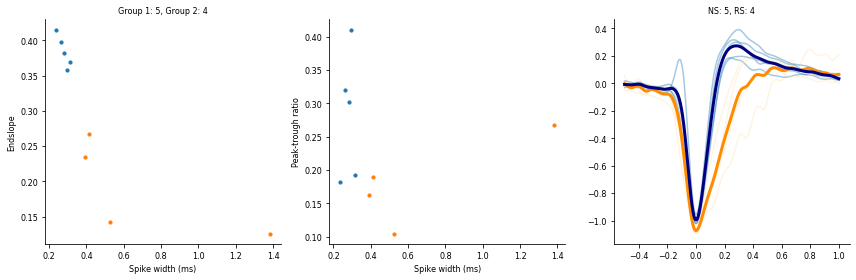

In [219]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 'a'"))

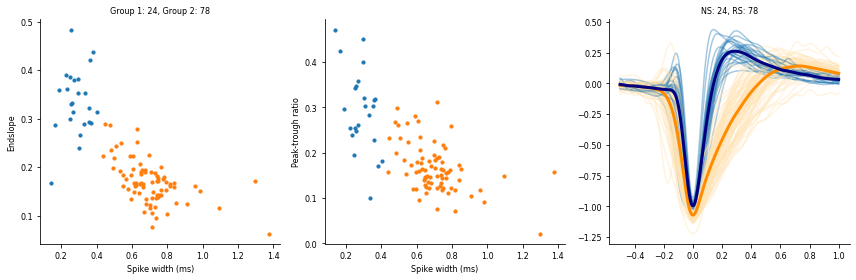

In [220]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 's'"))

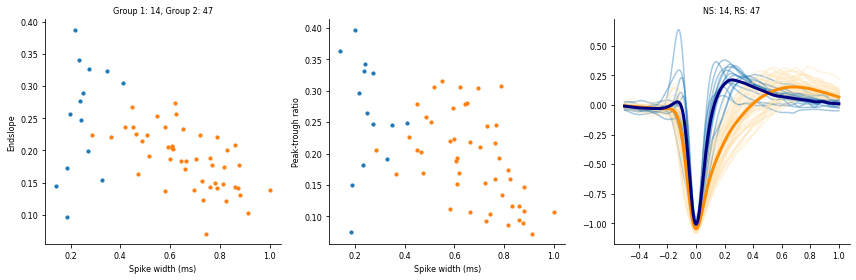

In [221]:
axes = plot_waveforn_cluster(wave_DF.query("phototag == 'n'"))

In [117]:
wave_DF.head()

,id,sw,ptr,fwhm,es,bs,trough,waveform_norm,isolation,spike_type,siteid,phototag
64,TNC006a-05-1,1.383887,0.259676,0.366813,0.126084,0.000000,4936.0,"[-0.032258681643630896, -0.033591720816232046,...",95.0000,broad,TNC006a,a
65,TNC006a-07-1,1.002313,0.100624,0.172200,0.138444,0.378840,4946.0,"[-0.006913689271593457, -0.0068859360220209845...",95.0000,broad,TNC006a,n
66,TNC006a-09-1,0.829840,0.106024,0.160173,0.200046,0.376927,4897.0,"[-0.002108801115674179, -0.0020789872610266075...",100.0000,broad,TNC006a,n
68,TNC006a-11-1,0.363533,0.158317,0.197893,0.220554,0.766700,4932.0,"[-0.0030235240569748967, -0.002992109861073962...",96.0737,broad,TNC006a,n
69,TNC006a-30-1,0.860180,0.112503,0.252560,0.143016,0.492000,4947.0,"[-0.010084146169305558, -0.00991749975664133, ...",95.0000,broad,TNC006a,n


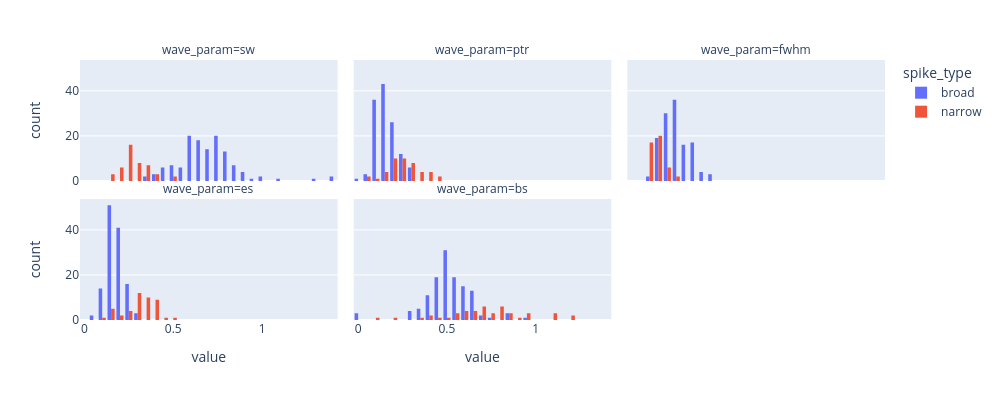

In [121]:
tohist = wave_DF.melt(id_vars=['id', 'phototag', 'spike_type'], value_vars=['sw', 'ptr', 'fwhm', 'es', 'bs'],
                      var_name='wave_param', value_name='value')


fig = px.histogram(tohist, x='value', facet_col='wave_param', color='spike_type', barmode='group', facet_col_wrap=3)

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

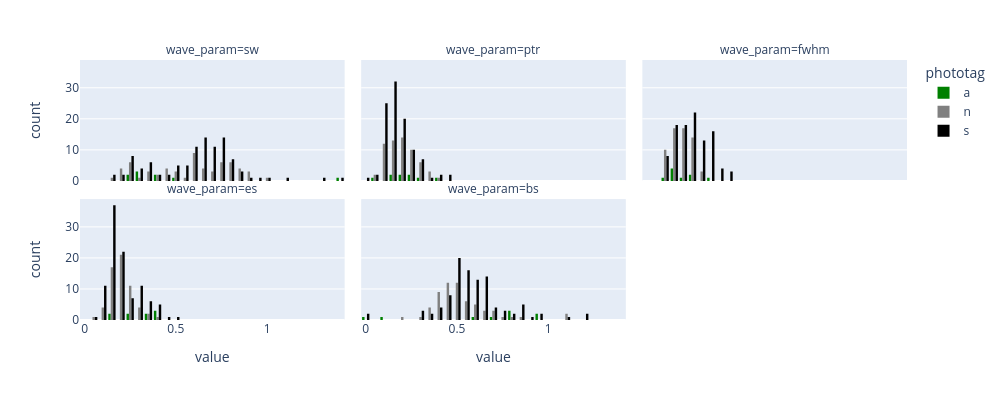

In [123]:
tohist = wave_DF.melt(id_vars=['id', 'phototag', 'spike_type'], value_vars=['sw', 'ptr', 'fwhm', 'es', 'bs'],
                      var_name='wave_param', value_name='value')

fig = px.histogram(tohist, x='value', facet_col='wave_param', color='phototag', barmode='group', facet_col_wrap=3,
                   color_discrete_map={"a": "green",
                                       "s": "black",
                                       "n": "gray"}, )

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

## focus on spike width
The photo tagged units are restricted to narrow waveforms, whereas they are spread across all other categories.
Let just split clustere based on spike waveforms

**here kmeans clusterse perform better than gaussian mixture**

In [222]:
type_DF_file = pl.Path(config['paths']['analysis_cache']) / '210816_CPN_celltype_DF'
toclust = jl.load(type_DF_file).dropna(subset=['sw', 'ptr', 'fwhm', 'es', 'bs'], how='any')


csw = toclust['sw'].values
cptr = toclust['ptr'].values
ces = toclust['es'].values

# X = np.stack((csw, cptr, ces), axis=1)
X = csw[:, None]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
labels = kmeans.predict(X)
# gmm = GaussianMixture(n_components=2).fit(X)
# labels = gmm.predict(X)

named_labels = np.empty(len(labels), dtype=object)
if csw[labels == 1].mean() < csw[labels == 0].mean():
    named_labels[labels == 1] = 'narrow'
    named_labels[labels == 0] = 'broad'
else:
    named_labels[labels == 0] = 'narrow'
    named_labels[labels == 1] = 'broad'

toclust['sw_type'] = named_labels

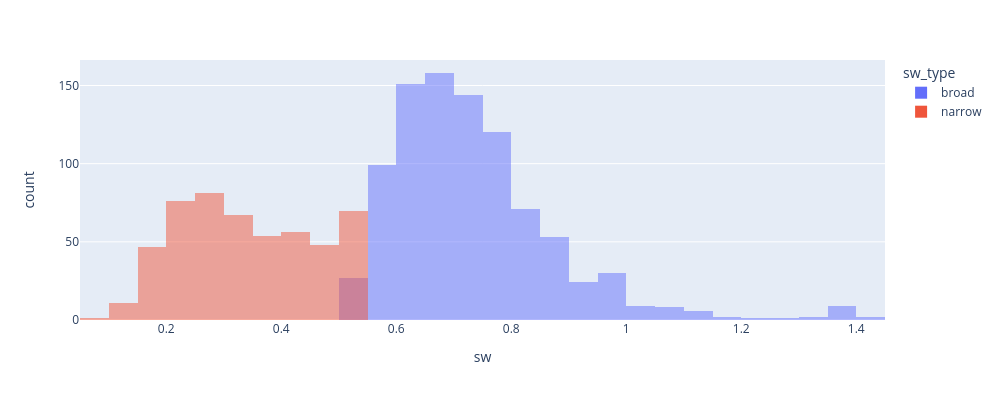

In [229]:
fig = px.histogram(toclust, x='sw', color='sw_type', barmode='overlay')

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

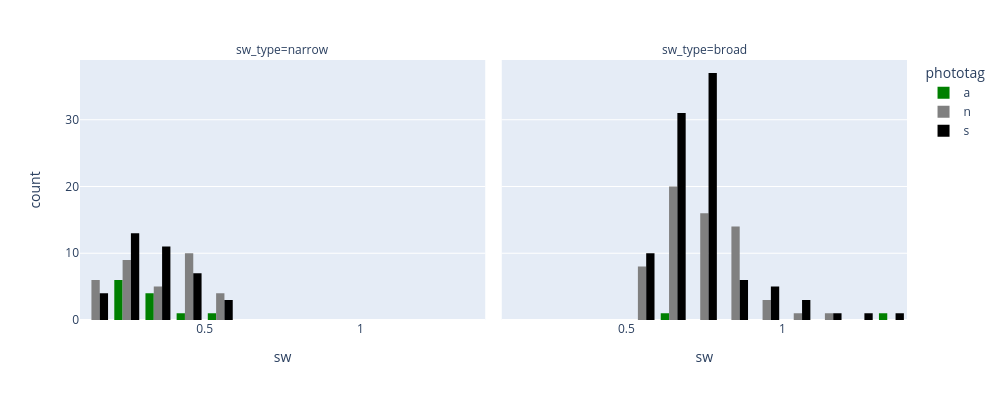

In [230]:
fig = px.histogram(toclust.dropna(subset=['phototag']), x='sw', facet_col='sw_type', color='phototag', barmode='group',
                   color_discrete_map={"a": "green",
                                       "s": "black",
                                       "n": "gray"},
                   category_orders={'sw_type': ['narrow', 'broad']})

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)
# fig.show()

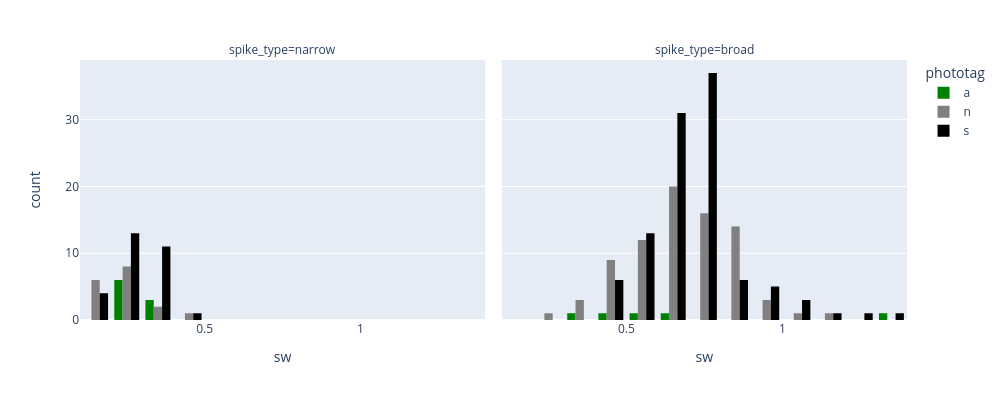

In [226]:
fig = px.histogram(toclust.dropna(subset=['phototag']), x='sw', facet_col='spike_type', color='phototag',
                   barmode='group',
                   color_discrete_map={"a": "green",
                                       "s": "black",
                                       "n": "gray"},
                   category_orders={'spike_type': ['narrow', 'broad']})

img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)
# fig.show()

# effects by time chunks
letsfocus on significant contextual modulation amplitude for chunks A and B, keeping instances that are significant
at any point in time

In [271]:
# Cluster Mass significant contextual effects
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220804_significant_abs_deltaFR_DF'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220818_abs_deltaFR_DF'

# load integral across time chunks and whole lenght
# metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D']
metrics = ['integral', 'integral_nosig_A', 'integral_nosig_B', 'integral_nosig_C', 'integral_nosig_D']
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' "
                                    # f"and value > 0"
                                    )

# now filter the chunks based on the significance of the full probe
DF = pd.merge(DF.query("metric == 'integral' and value > 0").loc[:, ['id', 'context_pair', 'probe']],
              DF.query(f"metric in {[m for m in metrics if m != 'integral']}"),
              on=['id', 'context_pair', 'probe'], validate="1:m" )


DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr',
                 'analysis', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)
DF = add_classified_contexts(DF)

DF['chunk'] = DF.metric.str.split('_').str[-1]
DF['metric'] = DF.metric.str.split('_').str[0]

for col in ['id','context_pair','probe','site', 'region', 'metric', 'trans_pair', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
print(DF.shape)
DF.head()

(183632, 9)


,id,context_pair,probe,value,metric,site,region,trans_pair,chunk
0,TNC044a-48-1,00_02,1,110.353371,integral,TNC044a,A1,diff_silence,A
1,TNC044a-48-1,00_02,1,79.376984,integral,TNC044a,A1,diff_silence,B
2,TNC044a-48-1,00_02,1,25.168314,integral,TNC044a,A1,diff_silence,C
3,TNC044a-48-1,00_02,1,36.784458,integral,TNC044a,A1,diff_silence,D
4,TNC044a-41-1,00_03,1,301.273346,integral,TNC044a,A1,diff_silence,A


In [272]:
normalizer =DF.groupby(by=['metric'], observed=True).agg(grand_mean=('value',np.mean)).reset_index()

toregress = pd.merge(DF, normalizer, on=['metric'], validate="m:1")
toregress['norm_val'] = toregress['value']/toregress['grand_mean']
toregress = pd.merge(toregress,
                     toclust.loc[:,['id', 'spike_type', 'phototag', 'sw_type', 'sw']],
                     on='id', validate="m:1")

# the simplest approach is to manually map the 4 categories into onehots
# onehot order: diff same silence
mapper={'diff_diff':(1,0,0), 'diff_same':(1,1,0), 'diff_silence':(1,0,1), 'same_silence':(0,1,1)}
toregress['onehot'] = toregress['trans_pair'].replace(mapper)

onehotdf = pd.DataFrame(toregress['onehot'].to_list(), columns = ['diff', 'same', 'silence'])
toregress = pd.concat([toregress, onehotdf], axis=1)

toregress.drop(columns='onehot', inplace=True)
del(onehotdf)
print(toregress.shape)
toregress.head()

(176572, 18)


,id,context_pair,probe,value,metric,site,region,trans_pair,chunk,grand_mean,norm_val,spike_type,phototag,sw_type,sw,diff,same,silence
0,TNC044a-48-1,00_02,1,110.353371,integral,TNC044a,A1,diff_silence,A,109.011002,1.012314,broad,NaN,broad,0.614727,1,0,1
1,TNC044a-48-1,00_02,1,79.376984,integral,TNC044a,A1,diff_silence,B,109.011002,0.728156,broad,NaN,broad,0.614727,1,0,1
2,TNC044a-48-1,00_02,1,25.168314,integral,TNC044a,A1,diff_silence,C,109.011002,0.230879,broad,NaN,broad,0.614727,1,0,1
3,TNC044a-48-1,00_02,1,36.784458,integral,TNC044a,A1,diff_silence,D,109.011002,0.337438,broad,NaN,broad,0.614727,1,0,1
4,TNC044a-48-1,00_06,1,96.801201,integral,TNC044a,A1,diff_silence,A,109.011002,0.887995,broad,NaN,broad,0.614727,1,0,1


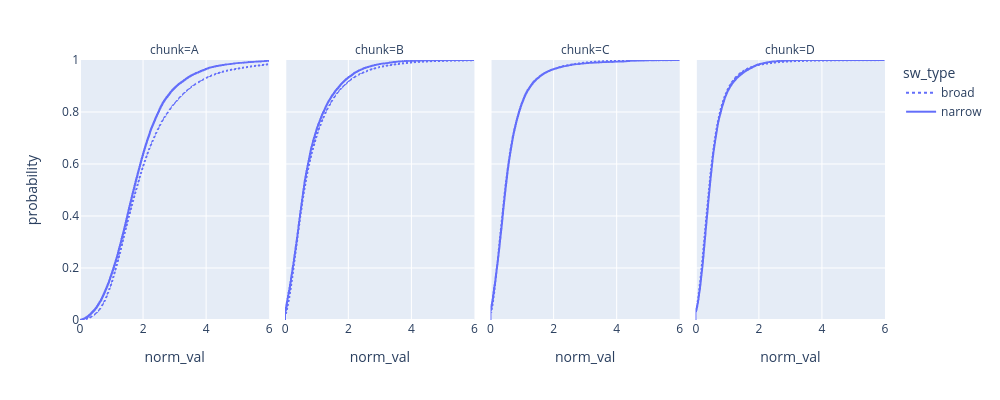

In [300]:
toplot = toregress.dropna(subset='sw_type')
fig = px.ecdf(toplot, x="norm_val", line_dash='sw_type', facet_col='chunk',
              line_dash_map={'narrow': 'solid',
                             'broad': 'dot'})
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [301]:
# d = toregress.dropna(subset='sw_type')
# mod = ols("norm_val ~ C(sw_type) * C(chunk)", data=toplot)
mod = ols("norm_val ~ C(sw_type):C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                 1.342e+04
Date:                Thu, 18 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:23:00   Log-Likelihood:            -2.1204e+05
No. Observations:              176572   AIC:                         4.241e+05
Df Residuals:                  176564   BIC:                         4.242e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## phototag

/tmp/ipykernel_20970/2551291976.py:2: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.

/tmp/ipykernel_20970/2551291976.py:5: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



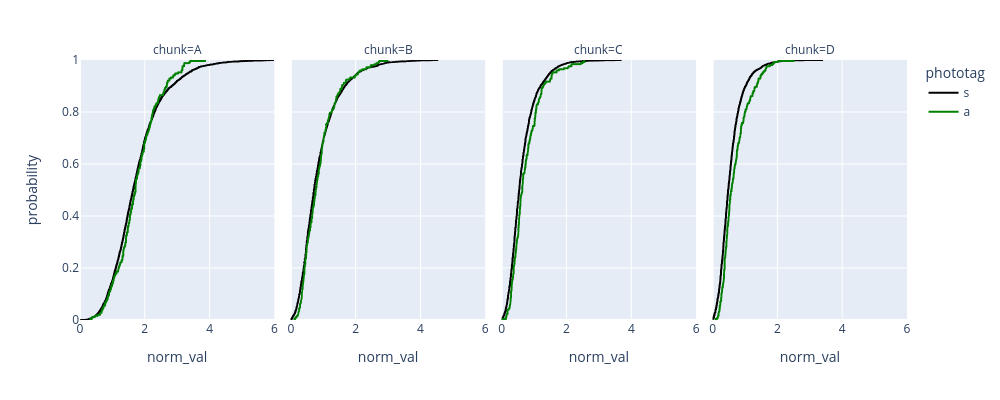

In [302]:
toplot = toregress.dropna(subset='phototag').query("phototag in ['a', 's']").copy()
toplot.phototag.cat.remove_unused_categories(inplace=True)

d = toregress.dropna(subset='sw_type').query("phototag in ['a', 's']").copy()
d.phototag.cat.remove_unused_categories(inplace=True)
fig = px.ecdf(toplot, x="norm_val", color='phototag', facet_col='chunk',
              color_discrete_map={"a": "green",
                                  "s": "black",
                                  "n": "gray"},)
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [303]:
mod = ols("norm_val ~ C(phototag):C(chunk)", data=toplot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               norm_val   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     1688.
Date:                Thu, 18 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:25:34   Log-Likelihood:                -15523.
No. Observations:               17684   AIC:                         3.106e+04
Df Residuals:                   17676   BIC:                         3.112e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [305]:
toplot.groupby(['id','phototag']).agg(value=('value',np.mean)).groupby('phototag').agg('count')

,value
phototag,
a,10
s,110


## double trouble

In [296]:
double_df = toregress.dropna(subset=['sw_type', 'phototag'], how='any').query("phototag in ['a', 's']").copy()
double_df.phototag.cat.remove_unused_categories(inplace=True)

double_df['double_class'] = double_df['spike_type'].astype(str) + '_' + double_df['phototag'].astype(str)
double_df['double_class'] = double_df['double_class'].astype('category')
double_df.reset_index(drop=True, inplace=True)
double_df.head()

/tmp/ipykernel_20970/1208824776.py:2: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



,id,context_pair,probe,value,metric,site,region,trans_pair,chunk,grand_mean,norm_val,spike_type,phototag,sw_type,sw,diff,same,silence,double_class
0,TNC008a-01-1,00_01,1,231.728607,integral,TNC008a,A1,same_silence,A,109.011002,2.125736,broad,s,narrow,0.507853,0,1,1,broad_s
1,TNC008a-01-1,00_01,1,84.058418,integral,TNC008a,A1,same_silence,B,109.011002,0.771100,broad,s,narrow,0.507853,0,1,1,broad_s
2,TNC008a-01-1,00_01,1,59.068077,integral,TNC008a,A1,same_silence,C,109.011002,0.541854,broad,s,narrow,0.507853,0,1,1,broad_s
3,TNC008a-01-1,00_01,1,77.242867,integral,TNC008a,A1,same_silence,D,109.011002,0.708579,broad,s,narrow,0.507853,0,1,1,broad_s
4,TNC008a-01-1,00_07,1,188.563477,integral,TNC008a,A1,diff_silence,A,109.011002,1.729766,broad,s,narrow,0.507853,1,0,1,broad_s


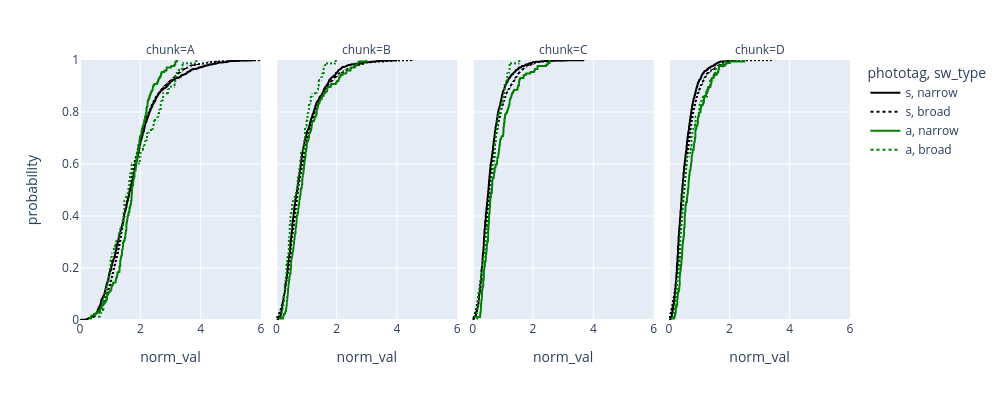

In [297]:
toplot = double_df

fig = px.ecdf(toplot, x="norm_val", color='phototag', line_dash='sw_type', facet_col='chunk',
              color_discrete_map={"a": "green",
                                  "s": "black",
                                  },
              line_dash_map={'narrow': 'solid',
                             'broad': 'dot'}
              )
fig.update_xaxes(range=[0, 6])
fig.update_yaxes(range=[0, 1])
img_bytes = fig.to_image(format="png", width=1000, height=400)
Image(img_bytes)

In [ ]:
mod = ols("norm_val ~ C(sw_type) * C(chunk)", data=d)
res = mod.fit()
print(res.summary())

# list of CPN sites to phototag
nothing special, just to keep track of it

In [149]:
all_proc_sites = set(get_phototags().siteid)

all_opto_sites={'ARM004e', 'TNC006a', 'TNC008a', 'TNC009a', 'TNC010a', 'TNC011a',
       'TNC012a', 'TNC013a', 'TNC014a', 'TNC015a', 'TNC016a', 'TNC017a',
       'TNC018a', 'TNC019a', 'TNC020a', 'TNC021a', 'TNC022a', 'TNC023a',
       'TNC024a', 'TNC029a', 'TNC043a', 'TNC044a', 'TNC045a', 'TNC047a',
       'TNC048a', 'TNC049a', 'TNC050a', 'TNC051a', 'TNC062a', 'CLT027c',
       'CLT028c', 'CLT031c', 'CLT032c', 'CLT033c', 'CLT034c', 'CLT035c',
       'CLT036c', 'CLT037c', 'CLT038a', 'CLT039c', 'CLT040c', 'CLT041c',
       'CLT042a', 'CLT043b', 'CLT044d', 'CLT045d', 'CLT048c', 'CLT049c'}

all_ctx_sites= set(DF.site.unique())


all_unproc = set(all_opto_sites).difference(set(all_proc_sites))
ctx_unproc = all_unproc.intersection(set(all_ctx_sites))
ctx_unproc

{'TNC024a',
 'TNC029a',
 'TNC043a',
 'TNC044a',
 'TNC045a',
 'TNC047a',
 'TNC048a',
 'TNC049a',
 'TNC050a',
 'TNC051a'}